## Meghana Ravikumar

### KNN for digit classification and joke recommenders, Latent Factoring


In [1]:
from sklearn import preprocessing
import numpy as np
import scipy.io
import math
import random
import itertools
import matplotlib.pylab as plt
%matplotlib inline
import csv

## Data Processing
### The digit data is imported and normalized by dividing each pixel by the largest pixel value. This takes away constrast differences.

In [2]:
def importDigit(path_data = "./data/mnist_data/images.mat"):
    data_train = scipy.io.loadmat(path_data)['images']
    data_trainF = np.zeros((60000,784))
    for dt2 in range(0,60000):
        data_trainF[dt2] = data_train[:,:,dt2].reshape(784)
    max_pixel = data_train.max()
    final_data_train = np.random.permutation(np.true_divide(data_trainF,max_pixel))
    return final_data_train

In [3]:
digit_data = importDigit()

## kMeans implementation
### This approach begins by randomly sampling digit data from the given data matrix to use as centers. Centers are repeatedly updated and clusters are repeatedly formed. This cyclic process is repeated until the clusters no longer change. 
### Eucledian distance used as the distance function

In [221]:
class kMeans(object):
    def __init__(self, data,k):
        self.data = data
        self.k = k
        self.centers = None
        self.Y = None
        
    def setCenters(self):
        self.centers = np.random.choice(self.data.shape[0],self.k, replace = False)
    
    def calcAvg(self,clusters):
        clustAvg = []
        for clust in clusters.values():
            clustAvg.append(np.mean(self.data[clust],axis=0))
        return clustAvg
    
    def update(self, clustAvg, clusters):
        '''Method will go through and calculate the closest cluster to each sample.'''
        
        allDiff = np.array([])
        for cl in range(self.k):
            diff = np.linalg.norm(self.data-clustAvg[cl],axis=1).reshape(self.data.shape[0],1)
            if allDiff.shape[0]==0:
                allDiff = np.array(diff)
            else:
                allDiff = np.hstack((allDiff,diff))
        self.Y = np.argmin(allDiff,axis=1)

        for cl2 in range(self.k):
            clusters[cl2]=np.where(self.Y==cl2)[0]
        return clusters
        
    def classification(self):
        oldY = np.zeros(self.data.shape[0])
        self.Y = -1*np.ones(self.data.shape[0])
        self.setCenters()
        clusters = {}
        for ind in range(self.k):
            clusters[ind] = np.array([self.centers[ind]])
        n = 0
        while (np.all(oldY==self.Y)== False):
            clustAvg = self.calcAvg(clusters)
            oldY = self.Y
            clusters = self.update(clustAvg, clusters)
            n = n+1
        print "iteration for"+" "+str(self.k)+" "+"finished in"+ " "+ str(n)
        return clustAvg,self.Y
    
    def plotting(self,clustAvg):
        ##plotting each centroid
        for clust in clustAvg:
            plt.figure()
            plt.imshow(clust.reshape(28,28))
            plt.show()
                    

iteration for 5 finished in 152


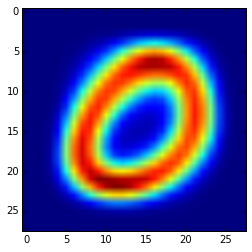

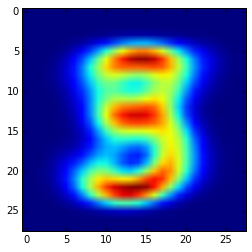

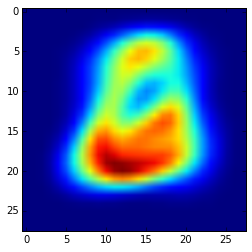

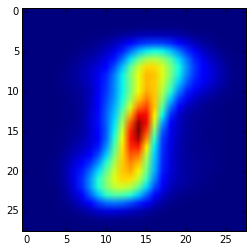

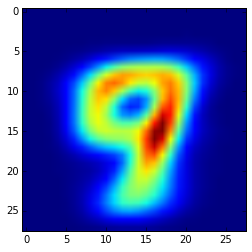

iteration for 10 finished in 81


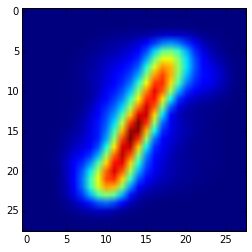

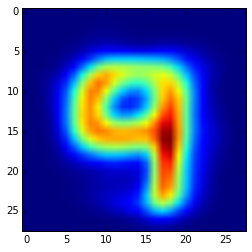

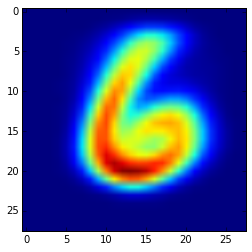

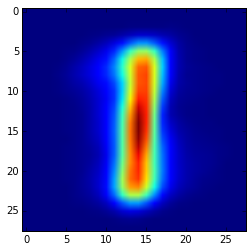

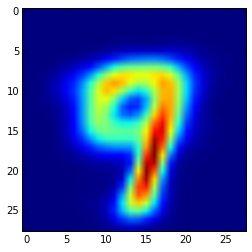

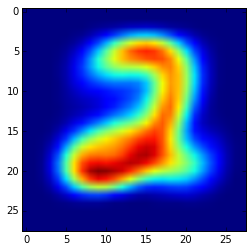

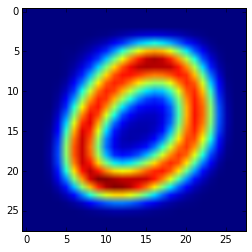

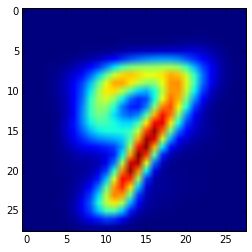

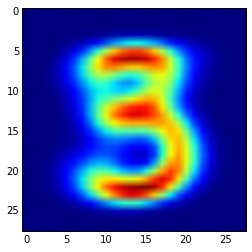

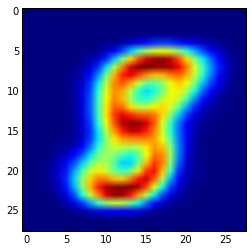

iteration for 20 finished in 149


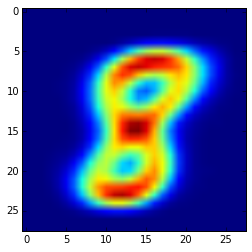

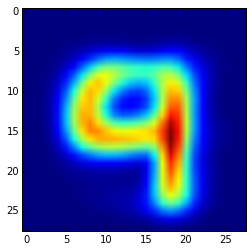

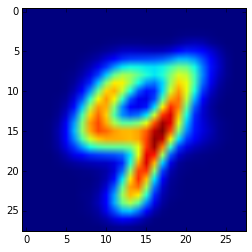

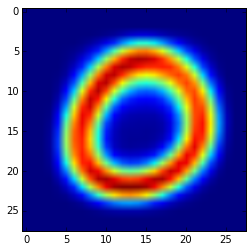

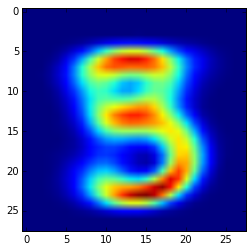

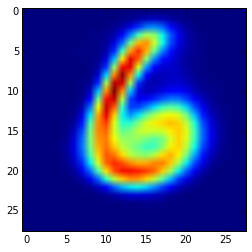

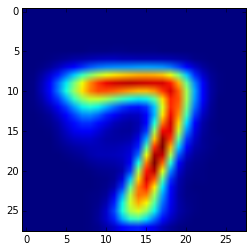

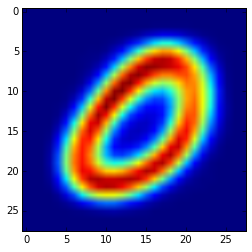

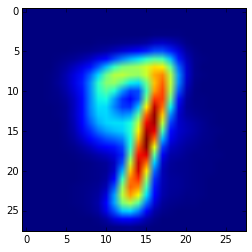

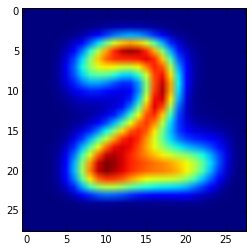

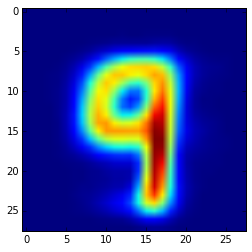

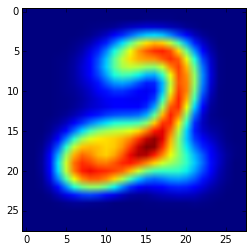

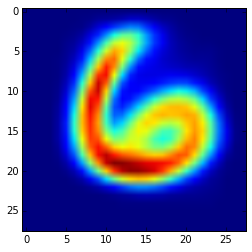

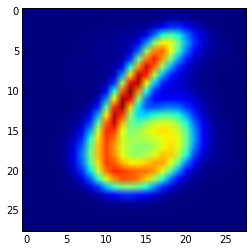

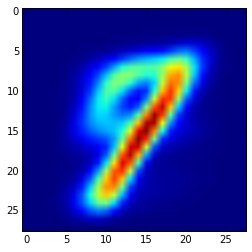

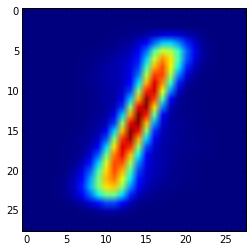

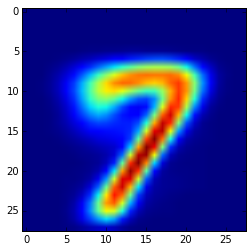

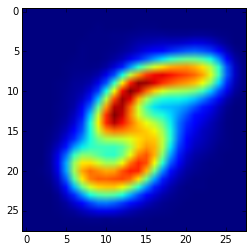

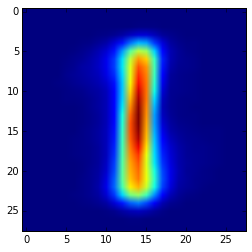

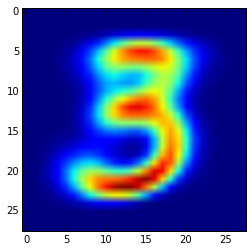

In [222]:
pred = []
for ind in [5,10,20]:
    NN = kMeans(data=digit_data, k=ind)
    clustalAvg, Y = NN.classification()
    NN.plotting(clustalAvg)
    pred.append(Y)

### As seen above, the most accurate centroids are created with a k value of 20. This is because a larger value of k indicates the existence of more clusters, which allows for digits to be classified more distinctly according to their features. It essentially allow for 3s to be distinguised from 5s by allowing for the anomolies found in the digit data.

## Joke Recommender System
## kNN implemented

In [2]:
def importJokeData(path_train,path_query,path_validation):
    data_train = scipy.io.loadmat(path_train)['train']
    
    with open(path_query, 'rb') as csvfile:
        queryreader = csv.reader(csvfile,delimiter=",")
        joke_query = np.array([map(int,row) for row in queryreader])
    
    with open(path_validation,'rb') as csvfile2:
        validreader = csv.reader(csvfile2,delimiter=",")
        joke_validation = np.array([map(int,row) for row in validreader])
    
    return data_train, joke_query, joke_validation

In [3]:
joke_data, joke_query, joke_validation = importJokeData('./data/joke_data/joke_train.mat',
                                                        './data/joke_data/query.txt', './data/joke_data/validation.txt')

## Joke Recommender System
### Following class's built for the simple and kNN methods for the joke recommendation system

In [45]:
class JokeRecommender(object):
    def __init__(self, joke_data, joke_validation, recType, k):
        self.joke_data = joke_data
        self.joke_validation = joke_validation
        self.recType = recType ##0= simple, 1=kNN, 2= latent factor 
        self.k = k
    
    def toRun(self):
        self.joke_data[np.where(np.isnan(self.joke_data))]=0 ##takes out the nans 
        if self.recType == 0:
            return self.simpleRec()
        if self.recType == 1:
            return self.kNNRec()
    
    def simpleRec(self):
        jokeAverages = np.mean(self.joke_data,axis=0)
        posInd = np.where(jokeAverages>=0)[0]
        predictions = self.joke_validation.copy()
        for rowInd in range(predictions.shape[0]):
            if predictions[rowInd,1] in posInd:
                predictions[rowInd,2]=1
            else:
                predictions[rowInd,2]=0
        accuracy = self.predAcc(predictions)
        return accuracy, predictions
    
    def modifyingMatrix(self, predictions, allPos):
        for d in range(predictions.shape[0]):
            currInd = predictions[d,0]-1,predictions[d,1]-1
            if allPos[currInd] >= 0:
                predictions[d,2]=1
            else:
                predictions[d,2]=0
        return predictions
    
    def kNNRec(self):
        predictions = self.joke_validation.copy()
        #joke_data = self.joke_data[:100,]
        joke_data = self.joke_data
        allPos = np.zeros(joke_data[:100,].shape)
        for rowInd in range(100):
            kIndClos = self.kNN(rowInd)
            kData = np.mean(joke_data[kIndClos,:],axis=0)
            allPos[rowInd]=kData
        predictions = self.modifyingMatrix(predictions,allPos)
        accuracy = self.predAcc(predictions)
        return accuracy, predictions
            
    def kNN(self,currInd):
        distMat = np.linalg.norm(self.joke_data-self.joke_data[currInd],axis=1)
        distMat = np.argsort(distMat)
        return distMat[:self.k]
        
    def predAcc(self,predictions):
        preds = predictions[:,2]
        actual = self.joke_validation[:,2]
        acc = float(len(np.where(preds == actual)[0]))/float(len(actual))
        print "the accuracy for this method is:", acc
        return acc
        

## Simplest Recommender System
### Recommendations for this method were built by averaging over all the recommendations for jokes. 
### Any NaNs found in the original matrix were set to 0 for computation purposes.

In [46]:
simpleRecommender = JokeRecommender(joke_data, joke_validation,0,0)
acc_Simple, pred_Simple = simpleRecommender.toRun()

the accuracy for this method is: 0.552574525745


## kNN Recommender System 
### Recommendations for the kNN method were built by finding the kth nearest neighbor for each of the data points Any NaNs foudn in the original matrix were set to 0 
### As expected, he highest accuracy was found with k=1000. An increasing k value for kNN will lead to better predictions as accounting for more neighbors will lead to a better averaging of the features to determine/predict the relationship between user i and joke j

In [51]:
def runRecKNN():
    accuracies = []
    preds = []
    for i in [10,100,1000]:
        print "the k-value is:"+str(i)
        kNNRecommender = JokeRecommender(joke_data, joke_validation, recType=1,k=i)
        acc, pred = kNNRecommender.toRun()
        accuracies.append(acc)
        preds.append(pred)
    return accuracies, preds

In [52]:
accuracies, preds = runRecKNN()

the k-value is:10
the accuracy for this method is: 0.639837398374
the k-value is:100
the accuracy for this method is: 0.689159891599
the k-value is:1000
the accuracy for this method is: 0.694308943089


### As seen above, the kNN method had a much higher accuracy than the Simple recommender system. This is due to the fact that taking into account common features and such allows for finding better relationships between joke preferences and users. This can be expanded into takign into account how an increasing k-value will lead to a higher accuracy as well.

## Latent Factor Model

### The following class is built for the latent factor model analysis for the joke recommendations

In [49]:
##new version
class latentFactor(object):
    def __init__(self,joke_data,joke_validate,epsilon,lambd,dim=[2,5,10,15,20]):
        self.joke_data = joke_data
        self.validation = joke_validate
        self.epsilon = epsilon
        self.lambd = lambd
        self.dim = dim ## will be a list to reduce computation of SVD
        self.U = None
        self.s = None
        self.V = None
    
    def SVD(self):
        self.joke_data[np.where(np.isnan(self.joke_data))]=0
        self.U,self.s,self.V = np.linalg.svd(self.joke_data, full_matrices=False)

    
    def train(self):
        toRtn = None
        for d in self.dim:
            U = self.U[:,:d]
            V = self.V[:d,:]
            s = np.diag(self.s[:d])
            USV = np.dot(U,np.dot(s,V))
            error = self.MSE(USV)
            print "the error for the d value of "+str(d)+" "+"is"+" "+str(error)
            pred = self.classify(USV)
            acc = self.accuracy(pred)
            if d == 10:
                toRtn = USV
        return USV
                
    def classify(self,UV):
        predictions = []
        for d in range(self.validation.shape[0]):
            currInd = self.validation[d,0]-1,self.validation[d,1]-1
            if UV[currInd] > 0:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
        
    
    def MSE(self,predictions):
        nonAN = np.square(predictions-self.joke_data)
        summed = np.sum(nonAN[-np.isnan(self.joke_data)])
        return summed 
    
    def accuracy(self,predictions):
        actual = self.validation[:,2]
        acc = float(len(np.where(predictions == actual)[0]))/float(len(actual))
        print "the accuracy for this dim is:", acc
        return acc
    
    def forKaggle(self,pred,testData):
        classifications = []
        for d in range(testData.shape[0]):
            currInd = testData[d,1]-1,testData[d,2]-1
            if pred[currInd] > 0:
                classifications.append(1)
            else:
                classifications.append(0)
        return classifications

    def gradUpdate(self):
        print 'in gradupdate'
        for d in self.dim:
            U = self.U[:,:d]
            V = self.V[:d,:]
            s = np.diag(self.s[:d])
            currDiff = math.pow(10,8)
            currLoss = 0
            while currDiff <= math.pow(10,10): 
                print "in while loop"
                indU = np.random.choice(U.shape[0],1)
                indV = np.random.choice(V.shape[0],1)
                inU = U[indU]
                inU = inU[-np.isnan(inU)]
                inV = V[indV]
                inV = inV[-np.isnan(inV)]
                rU = self.joke_data[indU,:]
                rV = self.joke_data[:,indV]
                newU, newV = self.SGD(inU,inV,d)
                newLoss = self.loss(USV)
                print "the error for the d value of "+str(d)+" "+"is"+" "+str(error)
                currDiff = newLoss-currLoss
                curLoss = newLoss
                pred = self.classify(USV)
                acc = self.accuracy(pred)
    
    def Loss(self,U,V):
        return np.square(np.dot(U,V)-self.joke_data)+self.lambd*np.linalg.norm(U)+self.lambd*np.linalg.norm(V)

    def SGD(self,inU,inV,d):
        '''Method will build a stochastic gradient descent to better approximate the classifications.
        Takes in indices to index a larger matrix'''
        dervU = 2*np.dot(np.dot(inU,inV)-self.joke_data,inV)+2*self.lambd*inU
        dervV = 2*np.dot(np.dot(inU,inV)-self.joke_data,inU)+2*self.lambd*inV
        newU = inU-self.epsil*dervU
        newV = inV-self.epsil*dervV
        return newU, newV

### Latent factor analysis using MSE
### As seen below, the highest accuracy for the latent factor reduction is found with a dimension value of 10. This accuracy then decreases as the dimension value increases. This is due to the fact that increasing the dimensions beyond a certain level can lead to an increase in noise in finding the directions that fit the data well.

In [50]:
latent = latentFactor(joke_data, joke_validation,0,0)
latent.SVD()
USV = latent.train()
classifications = latent.forKaggle(USV,joke_query)

/Users/meghanaravikumar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


the error for the d value of 2 is 20814819.1728
the accuracy for this dim is: 0.705149051491
the error for the d value of 5 is 19264405.1575
the accuracy for this dim is: 0.715447154472
the error for the d value of 10 is 17415305.8624
the accuracy for this dim is: 0.716531165312
the error for the d value of 15 is 15885976.0423
the accuracy for this dim is: 0.70379403794
the error for the d value of 20 is 14466309.8038
the accuracy for this dim is: 0.685907859079


### Latent factor analysis uisng SGD
### This was not implemented in a working fashion due to time constraints.
### In theory, the usage of a regularized MSE as the loss function will lead to a higher accuracy. This is due to the fact that the regularization and the learning rate will converge to a local maximum quickly when using stochastic gradient descent. Furthermore, the regularization will prevent the eigenvectors that are chosen from over-fitting to the given data and will be more useful in finding the major directions in new testing data.

## Kaggle
### Kaggle score for latent factor using MSE is 0.67


In [18]:
def writeToCSV(fileName, predictions):
    import csv
    with open(fileName, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Id','Category'])
        shl = 1
        for pred_l in predictions:
            writer.writerow([shl,int(pred_l)])
            shl = shl + 1    

In [19]:
writeToCSV('latentFactor_10.csv',classifications)